- Ligne transport
    <https://public.opendatasoft.com/explore/dataset/ligne-transport/table/?location=11,48.87194,2.60376&basemap=mb-931882>

- Decomposing trend, seasonal and residual time series elements
    <https://stackoverflow.com/questions/34457281/decomposing-trend-seasonal-and-residual-time-series-elements>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.float_format', lambda x: '%.1f' % x)
from datetime import datetime, date
import math
import matplotlib
import matplotlib.pyplot as plt

import geopandas
import branca.colormap as cm
import folium
from folium import plugins
from shapely.geometry import Point

In [2]:
vf = pd.read_csv('downloads/idf.1420_v3.csv')

communesidf_geo = geopandas.read_file('downloads/Communes_IDF.json', driver='JSON')
dept_geo = geopandas.read_file('downloads/departements.geojson', driver='GeoJSON')

/Users/jingwen/github/dvf/_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (14,16,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
communesidf_nonbois_geo = communesidf_geo[communesidf_geo['B_BOIS']=='Non']
communesidf_bois_geo = communesidf_geo[communesidf_geo['B_BOIS']=='Oui']

In [4]:
def calculate_vf_m2(nature_culture, valeur_fonciere, surface_terrain, surface_reelle_bati):
    if math.isnan(surface_terrain) == False and nature_culture in ['sols', 'jardins', "terrains d'agrément"]:
        return valeur_fonciere / surface_terrain
    else:
        return valeur_fonciere / surface_reelle_bati

def grp_nbpiece(piece):
    if piece == 0 or piece > 4:
        return 'Others'
    else:
        return 'T%d' % int(piece)

In [5]:
vf = vf[(vf['type_local'] == 'Appartement') &
        (vf['nature_mutation'] == 'Vente') &
        (vf['valeur_fonciere'] > 0) &
        (vf['surface_reelle_bati'] > 0) &
        (vf['longitude'].isnull() == False) &
        (vf['latitude'].isnull() == False) &
        ((vf['lot1_numero'].notnull()) |
         (vf['lot1_surface_carrez'].notnull()) |
         (vf['lot2_surface_carrez'].notnull()) |
         (vf['lot3_surface_carrez'].notnull()) |
         (vf['lot4_surface_carrez'].notnull()) |
         (vf['lot5_surface_carrez'].notnull()) )]
vf = vf[[
    'id_mutation',
    'date_mutation',
    'numero_disposition',
    'nature_mutation',
    'valeur_fonciere',
    'adresse_numero',
    'adresse_suffixe',
    'adresse_nom_voie',
    'adresse_code_voie',
    'code_postal',
    'code_commune',
    'nom_commune',
    'code_departement',
    'type_local',
    'nature_culture',
    'surface_terrain',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'longitude',
    'latitude'
]]

vf = vf.drop_duplicates(['id_mutation'], keep=False)
vf['nb_piece_group'] = vf['nombre_pieces_principales'].map(grp_nbpiece)
vf['valeur_m2'] = vf.apply(lambda row: calculate_vf_m2(row['nature_culture'], row['valeur_fonciere'],
                                                       row['surface_terrain'], row['surface_reelle_bati']),
                           axis='columns')
vf['valeurK_m2'] = vf['valeur_m2'] / 1000
vf.reset_index(drop=True, inplace=True)

In [6]:
vf.date_mutation = vf.date_mutation.apply(lambda s: datetime.strptime(s, '%Y-%m-%d'))
vf['Year'] = vf.date_mutation.apply(lambda d: d.strftime('%Y'))
vf['Month'] = vf.date_mutation.apply(lambda d: date(d.year, d.month, 1))

In [7]:
mth_amount_df = vf.groupby(['Month'])['id_mutation'].count().to_frame().reset_index()
mth_amount_df = mth_amount_df.rename(columns={'id_mutation':'nb_mutation'})
mth_avgprc_df = vf.groupby(['Month'])['valeurK_m2'].mean().to_frame().reset_index()
mth_avgprc_df = mth_avgprc_df.rename(columns={'valeurK_m2':'avg_valeurK_m2'})
mth_df = pd.merge(mth_amount_df, mth_avgprc_df, on='Month')

In [8]:
dept_mth_amount_df = pd.pivot_table(data=vf, columns='code_departement', index='Month',
                                    values='id_mutation', aggfunc='count')
dept_mth_avgprc_df = pd.pivot_table(data=vf, columns='code_departement', index='Month',
                                    values='valeurK_m2', aggfunc='mean')

## Visu tools

In [9]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

YEARS = mdates.YearLocator()
YEARFMT = mdates.DateFormatter('%Y')
MONTHS = mdates.MonthLocator()

def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def thousands_1dec(x, pos):
    return '%1.1f' % (x * 1e-3)

def millions_1dec(x, pos):
    return '%1.1f' % (x * 1e-6)

formatter_thousands = FuncFormatter(thousands)
formatter_thousands_1dec = FuncFormatter(thousands_1dec)
formatter_millions_1dec = FuncFormatter(millions_1dec)

In [10]:
def autolabel_simple_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                3 + height,
                '%1.1f' % height,
                fontsize=11, ha='center', va='center', color=color)


def autolabel_simple_keuros_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                0.2 + height,
                '%1.2fk€' % height,
                fontsize=11, ha='center', va='center', color=color)

def autolabel_simple_thousands_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                200 + height,
                '%1.1f' % (height * 1e-3),
                fontsize=11, ha='center', va='center', color=color)


## Time series: monthly average price per m2 & monthly transaction amount (globally)

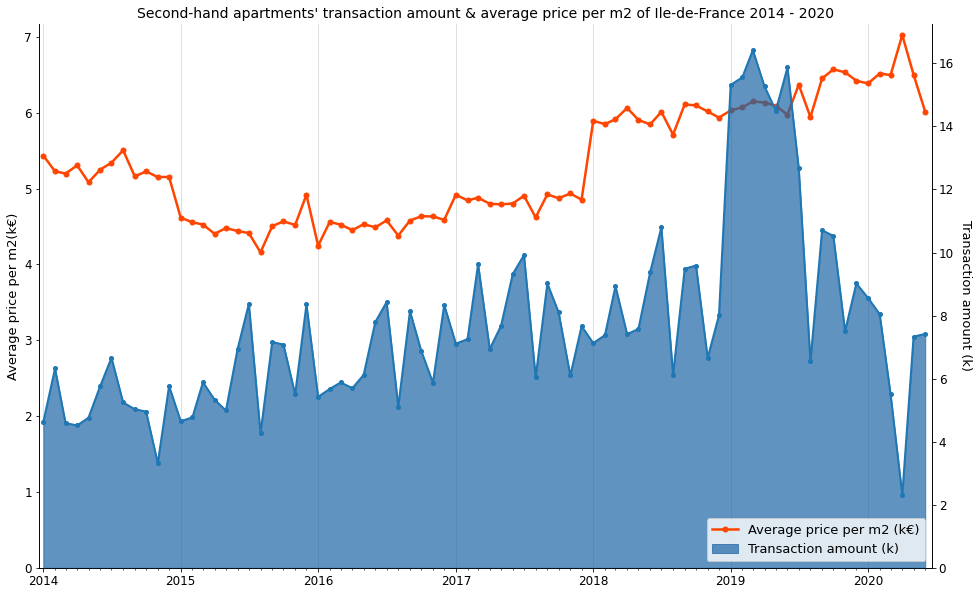

In [11]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
ax1.set_title('Second-hand apartments\' transaction amount & average price per m2 of Ile-de-France 2014 - 2020',
              fontdict={'fontsize': 14})

line_price, = ax1.plot(mth_df.Month,
                       mth_df.avg_valeurK_m2,
                       marker='.',
                       linewidth=2.5,
                       markersize=10,
                       color='orangered')

ax1.tick_params(labelsize=12)
ax1.set_xticks(mth_df.Month)
ax1.set_xlim(left=date(2013, 12, 20), right=date(2020, 6, 18))
ax1.set_ylim(bottom=0)
ax1.set_ylabel('Average price per m2(k€)', size=13)

ax1.xaxis.set_major_locator(YEARS)
ax1.xaxis.set_minor_locator(MONTHS)
ax1.xaxis.set_major_formatter(YEARFMT)
ax1.grid(axis='x', which='major', alpha=0.5)
ax1.spines['top'].set_visible(False)

ax_02 = ax1.twinx()
area_txamt = ax_02.fill_between(mth_df.Month,
                                mth_df.nb_mutation,
                                alpha=0.7,
                                color='#1D65A6')
ax_02.plot(mth_df.Month,
           mth_df.nb_mutation,
           linewidth=2,
           marker='.',
           markersize=8)

ax_02.tick_params(labelsize=12)
ax_02.set_ylim(bottom=0)
ax_02.spines['top'].set_visible(False)
ax_02.yaxis.set_major_formatter(formatter_thousands)
ax_02.set_ylabel('Transaction amount (k)', rotation=270, labelpad=18, size=13)
ax_02.legend(handles=(line_price, area_txamt),
             fontsize=13,
             labels=('Average price per m2 (k€)', 'Transaction amount (k)'), loc=4)

plt.show()
# plt.savefig('transaction_amount_unit_price_1420.png', bbox_inches='tight')

Compared to the transaction amount and average price's evolution in Paris, the indicators in Ile-de-France are more stable. The average price per m2 is slightly increased 25% (6.5/5.2-1) between January 2014 and June 2020. Concerning the transaction amount, it's similar as the tendance of Paris, the transaction amount arrives the yearly lowest point in August, which might because people go on holiday at that time; on the contrary, the transactions in July or September are higher than other months, which means that people usually sign the purchase promise in May or July (supposed that we have 2 months for negotiating the credit between the purchase promise and purchase agreement), so that they can sign the agreement before their holiday or before the school opening.

## Time series: monthly average price per m2 & monthly transaction amount per department

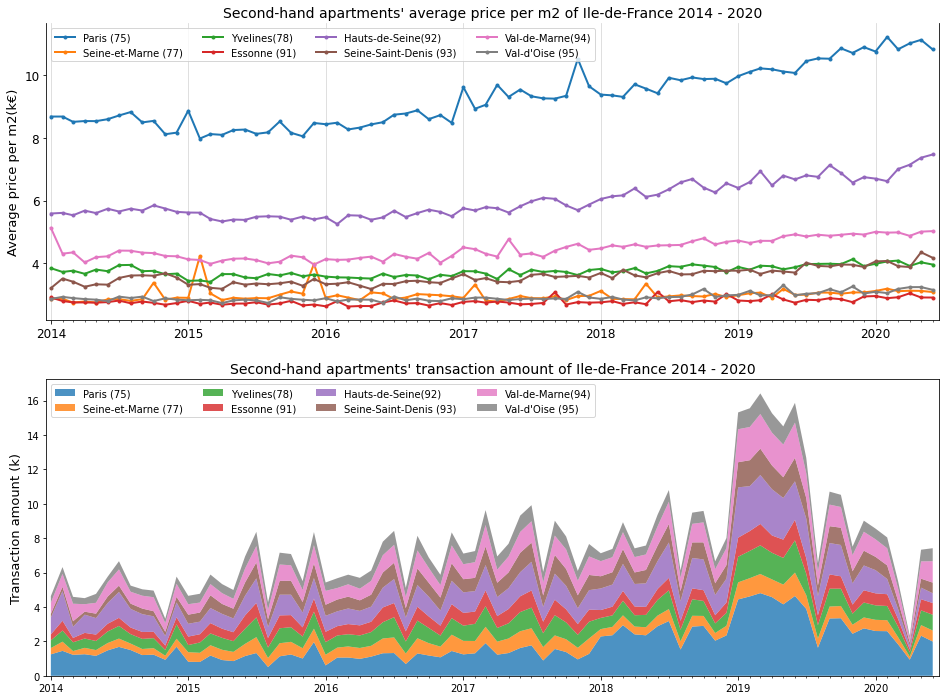

In [12]:
fig1, axarr = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
axarr[0].set_title('Second-hand apartments\' average price per m2 of Ile-de-France 2014 - 2020',
                   fontdict={'fontsize': 14})

line_75, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[75],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_77, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[77],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_78, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[78],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_91, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[91],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_92, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[92],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_93, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[93],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_94, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[94],
                         marker='.',
                         linewidth=2,
                         markersize=6)
line_95, = axarr[0].plot(dept_mth_avgprc_df.index,
                         dept_mth_avgprc_df[95],
                         marker='.',
                         linewidth=2,
                         markersize=6)

axarr[0].tick_params(labelsize=12)
axarr[0].set_xticks(mth_df.Month)
axarr[0].set_xlim(left=date(2013, 12, 20), right=date(2020, 6, 18))
# axarr[0].set_ylim(top=5)
axarr[0].set_ylabel('Average price per m2(k€)', size=13)

axarr[0].xaxis.set_major_locator(YEARS)
axarr[0].xaxis.set_minor_locator(MONTHS)
axarr[0].xaxis.set_major_formatter(YEARFMT)
axarr[0].grid(axis='x', which='major', alpha=0.5)
axarr[0].spines['top'].set_visible(False)
axarr[0].legend(handles=(line_75, line_77, line_78, line_91, line_92, line_93, line_94, line_95),
                ncol=4,
                labels=('Paris (75)', 'Seine-et-Marne (77)', 'Yvelines(78)', 'Essonne (91)',
                        'Hauts-de-Seine(92)', 'Seine-Saint-Denis (93)', 'Val-de-Marne(94)', 'Val-d\'Oise (95)'),
                loc=2)


axarr[1].set_title('Second-hand apartments\' transaction amount of Ile-de-France 2014 - 2020',
                   fontdict={'fontsize': 14})

axarr[1].stackplot(dept_mth_amount_df.index,
              [dept_mth_amount_df[75], dept_mth_amount_df[77], dept_mth_amount_df[78], dept_mth_amount_df[91],
               dept_mth_amount_df[92], dept_mth_amount_df[93], dept_mth_amount_df[94], dept_mth_amount_df[95]],
              labels=['Paris (75)', 'Seine-et-Marne (77)', 'Yvelines(78)', 'Essonne (91)', 'Hauts-de-Seine(92)',
                      'Seine-Saint-Denis (93)', 'Val-de-Marne(94)', 'Val-d\'Oise (95)'],
              alpha=0.8)
axarr[1].set_xticks(mth_df.Month)
axarr[1].set_xlim(left=date(2013, 12, 20), right=date(2020, 6, 18))
axarr[1].set_ylabel('Transaction amount (k)', size=13)

axarr[1].xaxis.set_major_locator(YEARS)
axarr[1].xaxis.set_minor_locator(MONTHS)
axarr[1].xaxis.set_major_formatter(YEARFMT)
axarr[1].yaxis.set_major_formatter(formatter_thousands)
axarr[1].legend(ncol=4, loc=2)


plt.show()
# plt.savefig('transaction_amount_unit_price_1420.png', bbox_inches='tight')

The line chart describes the second-hand apartments' average price per m2 of Ile-de-France, between January 2014 and June 2020. Obviously, the average price in Paris is the highest in Ile-de-France and its evolution is the highest as well, which increased 28%(11.1/8.7 - 1). Besides, the average price in Hauts-de-Seine is the second highest in Ile-de-France, it increased 36% (7.5/5.5-1); and the average price in Val-de-Marne increased 16% (5/4.3-1); the average price of other departments in Ile-de-France doesn't change a lot. Among 8 departments, the second-hand apartments are the most expensive in Paris until June 2020, which is 11k euros per m2, it's 47% higher than the price in Hauts-de-Seine and twice more expensive than second-hand apartments in Val-de-Marne.

The stacked area plot presentsthe second-hand arpatments' transaction amount of Ile-de-France, during the same period as the line chart. We can easily find that the transaction amount of Paris' second-hand apartments is more than other department of IDF, which is nearly 30% of transactions in IDF. Following Paris, the transaction amount of Hauts-de-Seine and Val-de-Marne are the second and third greatest of IDF. The peak of Paris's transaction is March 2019 (4807 transactions), for Hauts-de-Seine and Val-de-Marne are January 2019 and June 2019, respectively.

## Per nb piece: average price per m2 & transaction amount

In [13]:
nbpiece_tot_txamt = vf.groupby(['nb_piece_group'])['id_mutation'].count().to_frame().reset_index()
nbpiece_tot_txamt = nbpiece_tot_txamt.rename(columns={'id_mutation':'nb_transaction'})
nbpiece_tot_txamt['QP'] = nbpiece_tot_txamt['nb_transaction'] / nbpiece_tot_txamt['nb_transaction'].sum()

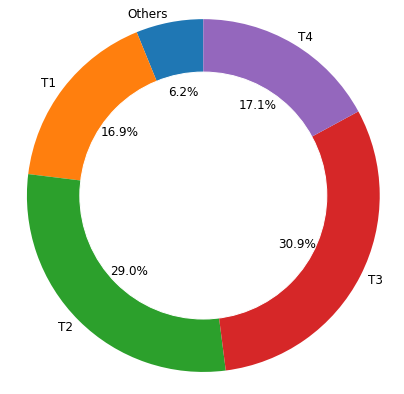

In [14]:
plt.figure(figsize=(7, 7))

my_circle = plt.Circle((0, 0), 0.7, color='white')
d = plt.pie(nbpiece_tot_txamt['QP'],
            labels=nbpiece_tot_txamt['nb_piece_group'],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.05)
plt.axis('equal')
plt.gca().add_artist(my_circle)

for i, (Others, T1, T2, T3, T4) in enumerate(d):
    if i > 0:
        Others.set_fontsize(12)
        T1.set_fontsize(12)
        T2.set_fontsize(12)
        T3.set_fontsize(12)
        T4.set_fontsize(12)

plt.show()
# plt.savefig('quotepart_piece_number.png', bbox_inches='tight')

This donut chart describes the quote-part of different pieces' apartment among the transactions. T2 and T3 hold nearly 60% transactions, nearly 17% transactions sold T1 apartments, other purchases are for larger apartments. Let's go further on the details.

In [15]:
nbpiece_df = vf.groupby(['nb_piece_group', 'code_departement'])['surface_reelle_bati', 'valeurK_m2'].mean().reset_index()
nbpiece_df = pd.concat([nbpiece_df[nbpiece_df['nb_piece_group'] != 'Others'],
                        nbpiece_df[nbpiece_df['nb_piece_group'] == 'Others']])
nbpiece_df = nbpiece_df.reset_index(drop=True)

/Users/jingwen/github/dvf/_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


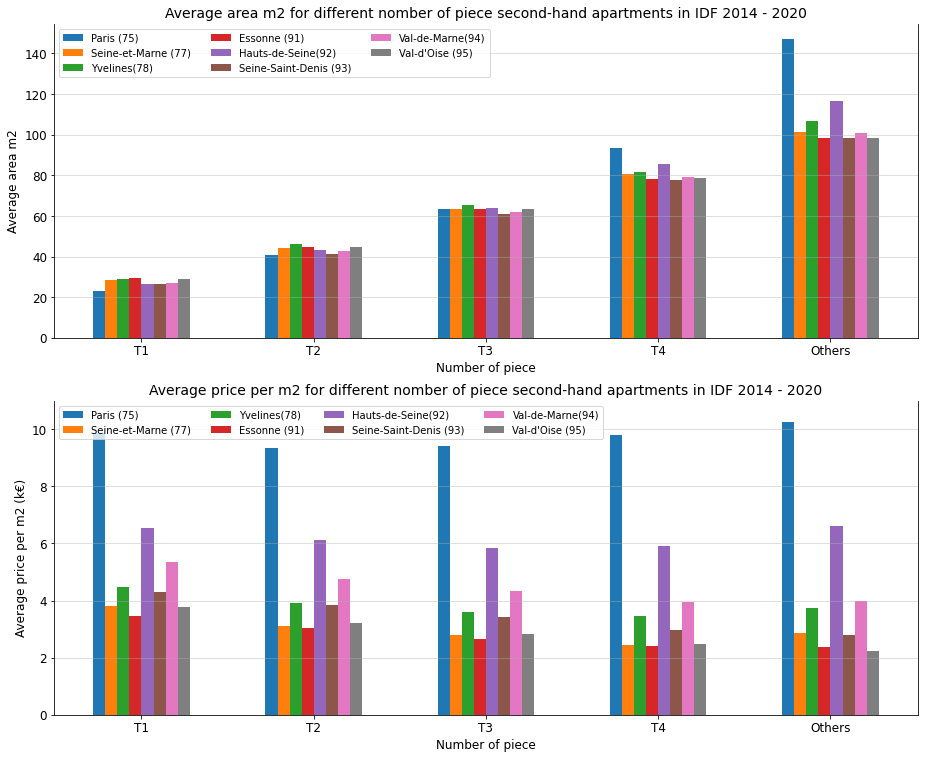

In [16]:
width = 0.07

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
ax[0].set_title('Average area m2 for different nomber of piece second-hand apartments in IDF 2014 - 2020',
                fontdict={'fontsize': 14})
areas75 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 75].reset_index(drop=True).index - 7/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 75].surface_reelle_bati,
                    width)
areas77 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 77].reset_index(drop=True).index - 5/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 77].surface_reelle_bati,
                    width)
areas78 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 78].reset_index(drop=True).index - 3/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 78].surface_reelle_bati,
                    width)
areas91 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 91].reset_index(drop=True).index - 1/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 91].surface_reelle_bati,
                    width)
areas92 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 92].reset_index(drop=True).index + 1/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 92].surface_reelle_bati,
                    width)
areas93 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 93].reset_index(drop=True).index + 3/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 93].surface_reelle_bati,
                    width)
areas94 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 94].reset_index(drop=True).index + 5/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 94].surface_reelle_bati,
                    width)
areas95 = ax[0].bar(nbpiece_df[nbpiece_df['code_departement'] == 95].reset_index(drop=True).index + 7/2 * width,
                    nbpiece_df[nbpiece_df['code_departement'] == 95].surface_reelle_bati,
                    width)

ax[0].tick_params(labelsize=12)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels(['T1', 'T2', 'T3', 'T4', 'Others'])
ax[0].set_xlabel('Number of piece', size=12)
ax[0].set_ylabel('Average area m2', size=12)

ax[0].grid(axis='y', which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].legend((areas75[0], areas77[0], areas78[0], areas91[0], areas92[0], areas93[0], areas94[0], areas95[0]),
             ('Paris (75)', 'Seine-et-Marne (77)', 'Yvelines(78)', 'Essonne (91)', 'Hauts-de-Seine(92)',
              'Seine-Saint-Denis (93)', 'Val-de-Marne(94)', 'Val-d\'Oise (95)'),
             ncol=3)

ax[1].set_title('Average price per m2 for different nomber of piece second-hand apartments in IDF 2014 - 2020',
                fontdict={'fontsize': 14})
val75 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 75].reset_index(drop=True).index - 7/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 75].valeurK_m2,
                  width)
val77 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 77].reset_index(drop=True).index - 5/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 77].valeurK_m2,
                  width)
val78 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 78].reset_index(drop=True).index - 3/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 78].valeurK_m2,
                  width)
val91 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 91].reset_index(drop=True).index - 1/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 91].valeurK_m2,
                  width)
val92 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 92].reset_index(drop=True).index + 1/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 92].valeurK_m2,
                  width)
val93 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 93].reset_index(drop=True).index + 3/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 93].valeurK_m2,
                  width)
val94 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 94].reset_index(drop=True).index + 5/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 94].valeurK_m2,
                  width)
val95 = ax[1].bar(nbpiece_df[nbpiece_df['code_departement'] == 95].reset_index(drop=True).index + 7/2 * width,
                  nbpiece_df[nbpiece_df['code_departement'] == 95].valeurK_m2,
                  width)

ax[1].tick_params(labelsize=12)
ax[1].set_xticks(range(5))
ax[1].set_xticklabels(['T1', 'T2', 'T3', 'T4', 'Others'])
ax[1].set_xlabel('Number of piece', size=12)
ax[1].set_ylabel('Average price per m2 (k€)', size=12)
ax[1].set_ylim(0, 11)

ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)
ax[1].legend((val75[0], val77[0], val78[0], val91[0], val92[0], val93[0], val94[0], val95[0]),
             ('Paris (75)', 'Seine-et-Marne (77)', 'Yvelines(78)', 'Essonne (91)', 'Hauts-de-Seine(92)',
              'Seine-Saint-Denis (93)', 'Val-de-Marne(94)', 'Val-d\'Oise (95)'),
             ncol=4)
plt.subplots_adjust(hspace=0.2, top=0.9, bottom=0.1, left=0.1, right=0.9)

plt.show()
# plt.savefig('unit_price_piece_number.png', bbox_inches='tight')

This graph describes the average price m2 for different nomber of piece second-hand apartments in Ile-de-France, between January 2014 and June 2020. I classed second-hand apartments into 5 groups in terms of piece's number: T1, which means one-room apartment with around 25 m2; T2, which means two-room apartment with around 40 m2; T3 presents three-room apartment around 60 m2; T4 are four-room apartments nearly 80 m2; T5 are five-room apartments larger than 100 m2. The average area of each class is similar in different department. For the T1 and T2 apartments, the ones in Paris are smaller than other departments; however, the second-hand apartments of T4 or larger ones are larger than other departments.

According to the second graph, we find that although T2 and T3 are much larger than T1, their unit prices are lower than the unit price of T1: the gap in Paris is 5.4% and 4.7%, respectively, with respect to T1; the gap in other departments is pretty large (11% and 19%). Moreover, average area of T4 is three times larger than T1, its unit price is 24% less expensive than T1 on average; except for Paris, T4's unit price is 1% more expensive than T1 in Paris. Why are T1 apartments that expensive per m2? That might be because there are many students or young workers, they need to rent a big enough apartment, which makes investors to invest T1 apartments, it also leads to higher demands on T1.

## Per department: unit price and sales amount

In [17]:
vf['points'] = vf.apply(lambda row: Point(row['longitude'],
                                          row['latitude']),
                        axis='columns')
vf['code_commune'] = vf['code_commune'].map(str)
vf['quartier'] = vf['code_commune'] + ':' + vf['nom_commune']

communesidf_geo = communesidf_geo.rename(columns={'C_INSEE':'code_commune'})
communesidf_geo['code_commune'] = communesidf_geo['code_commune'].map(str)

# vf_zero = communesidf_geo[communesidf_geo['C_INSEE'].isin(vf['code_commune'].unique())==False]

In [18]:
def prepare_df_4map(vf, code_departement, communesidf_geo):
#     communesidf_geo = communesidf_geo.rename(columns={'C_INSEE':'code_commune'})
#     communesidf_geo['code_commune'] = communesidf_geo['code_commune'].map(str)

    # filter dvf by department
    vf_quartier = vf[vf['code_departement'] == code_departement]
    vf_zero = communesidf_geo[communesidf_geo['code_commune'].isin(vf['code_commune'].unique())==False]
    vf_quartier = vf_quartier.groupby(['code_commune', 'quartier'])['valeurK_m2'].mean().reset_index()
    
    result = pd.merge(communesidf_geo[['code_commune', 'geometry']],
                      vf_quartier,
                      on='code_commune')
    result['valeurK_m2'] = result['valeurK_m2'].apply(lambda x: round(x, 2))    

    return result.fillna(0), vf_zero

In [19]:
vf_quartier_75, vf_zero_75 = prepare_df_4map(vf, 75, communesidf_geo) # vf_zero_75
vf_quartier_77, vf_zero_77 = prepare_df_4map(vf, 77, communesidf_geo)
vf_quartier_78, vf_zero_78 = prepare_df_4map(vf, 78, communesidf_geo)
vf_quartier_91, vf_zero_91 = prepare_df_4map(vf, 91, communesidf_geo)
vf_quartier_92, vf_zero_92 = prepare_df_4map(vf, 92, communesidf_geo)
vf_quartier_93, vf_zero_93 = prepare_df_4map(vf, 93, communesidf_geo)
vf_quartier_94, vf_zero_94 = prepare_df_4map(vf, 94, communesidf_geo)
vf_quartier_95, vf_zero_95 = prepare_df_4map(vf, 95, communesidf_geo)

In [20]:
vf_quartier_df = pd.concat([vf_quartier_75, vf_quartier_77, vf_quartier_78, vf_quartier_91,
                            vf_quartier_92, vf_quartier_93, vf_quartier_94, vf_quartier_95],
                           ignore_index=True)
vf_zero_df = pd.concat([vf_zero_75, vf_zero_77, vf_zero_78, vf_zero_91,
                        vf_zero_92, vf_zero_93, vf_zero_94, vf_zero_95],
                       ignore_index=True)

In [21]:
def style_zero_function(feature):
    default_style = {
        'fillOpacity': 0.03,
        'color': '#fbfbf9', # ''
        'weight': 0.0001
    }
        
    default_style['fillPattern'] = plugins.pattern.StripePattern(angle=-45)
        
    return default_style

In [22]:
from branca.element import Template, MacroElement

template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body>
 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; top: 20px;'>
     
<div class='legend-title'>Average price<br>(per m2)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#42ae67;opacity:1;'></span>0 k€ - 3 k€</li>
    <li><span style='background:#a5d883;opacity:1;'></span>3 k€ - 4 k€</li>
    <li><span style='background:#e5f4b5;opacity:1;'></span>4 k€ - 6 k€</li>
    <li><span style='background:#ffe8b1;opacity:1;'></span>6 k€ - 7 k€</li>
    <li><span style='background:#f8aa76;opacity:1;'></span>7 k€ - 9 k€</li>
    <li><span style='background:#e14144;opacity:1;'></span>> 9 k€</li>
    <li><span style='background:repeating-linear-gradient(
    -55deg,
    #ffffff,
    #ffffff 5px,
    #b2b2b2 5px,
    #b2b2b2 10px);
    opacity:0.7;'></span>No sales</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


In [23]:
template_title = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:25px; left: 60px; top: 0px;'>
<div class='legend-title'>Average price m2 of second-hand apartments</div>
<div class='legend-scale'><font size="3">Ile-de-France / Per district / between 2014 and 2020</font></div>
</div>

</body>
</html>

{% endmacro %}"""


In [24]:
vf_quartier_df['valeurK_m2'].describe(percentiles=(0.16, 0.32, 0.5, 0.67, 0.83, 1))

count    888.000000
mean       3.215507
std        1.751643
min        0.030000
16%        2.159200
32%        2.550000
50%        2.900000
67%        3.220000
83%        3.732100
100%      21.150000
max       21.150000
Name: valeurK_m2, dtype: float64

In [25]:
def draw_map_dept(quartier_df, zero_df, dept_geo, lat, lng, zoom_start=11):
    colormap_dept = cm.StepColormap(
    colors=['#42ae67', '#a5d883', '#e5f4b5',
            '#ffe8b1', '#f8aa76', '#e14144'],
    vmin=min(quartier_df['valeurK_m2']),
    vmax=max(quartier_df['valeurK_m2']),
    index=[0, 3, 4, 6, 7, 9, 22])

    # draw map
    vf_map = folium.Map(location=[lat, lng], zoom_start = zoom_start, tiles='cartodbpositron')

    style_function = lambda x: {
        'fillColor': colormap_dept(x['properties']['valeurK_m2']),
        'color': 'gray',
        'weight': 0.15,
        'fillOpacity': 1 # 0.7
    }

    folium.GeoJson(
        dept_geo[dept_geo['code'].isin(['75', '77', '78', '91', '92', '93', '94', '95'])], #dept_geo,
        style_function = lambda x: {
            'color': 'lightgray',
            'weight': 10,
            'fillOpacity': 0
        },
        name='Departement-gray-border').add_to(vf_map)


    folium.GeoJson(
        dept_geo[dept_geo['code'].isin(['75', '77', '78', '91', '92', '93', '94', '95'])], #dept_geo,
        style_function = lambda x: {
            'color': 'gray',
            'weight': 5,
            'fillOpacity': 0
        },
        name='Departement-gray-border').add_to(vf_map)

    
    folium.GeoJson(
        quartier_df,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['quartier', 'valeurK_m2'],
            aliases=['Quartier', 'Valeur fonciere m2 (k euros)'],
            localize=False
        ),
        name='Quartier').add_to(vf_map)

    folium.GeoJson(
        zero_df,
        style_function=style_zero_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['code_commune'],
            aliases=['Code commune'],
            localize=False
        ),
        name='Quartier').add_to(vf_map)

    folium.GeoJson(
        dept_geo[dept_geo['code'].isin(['75', '77', '78', '91', '92', '93', '94', '95'])], #dept_geo,
        style_function = lambda x: {
            'color': 'black',
            'weight': 2.5,
            'fillOpacity': 0
        },
        name='Departement').add_to(vf_map)

    folium.map.CustomPane('labels').add_to(vf_map)
    folium.TileLayer('CartoDBPositronOnlyLabels', pane='labels').add_to(vf_map)
    
    macro = MacroElement()
    macro._template = Template(template1)
    macro2 = MacroElement()
    macro2._template = Template(template_title)

    vf_map.get_root().add_child(macro)
    vf_map.get_root().add_child(macro2)

    
    return vf_map

In [26]:
idf_map = draw_map_dept(vf_quartier_df, vf_zero_df, dept_geo, 48.856614, 2.3522219, zoom_start=9)

In [ ]:
# idf_map.save('idf_map_1420.html')

**bar chart**

In [27]:
commune_sales = vf.groupby(['code_departement', 'nb_piece_group'])['id_mutation'].count().to_frame().reset_index()
commune_sales = commune_sales.rename(columns={'id_mutation':'nb_transaction'})
# commune_sales['arrondissement'] = commune_sales['code_commune'].apply(lambda x: str(x)[-2:])

commune_piece_sales = pd.pivot_table(data=commune_sales,
                                     index='code_departement',
                                     columns='nb_piece_group',
                                     values='nb_transaction',
                                     aggfunc='sum',
                                     margins=True).reset_index()
commune_piece_sales = commune_piece_sales.sort_values('All', ascending=False)
commune_piece_sales = commune_piece_sales[commune_piece_sales['code_departement'] != 'All']
commune_piece_sales['code_departement'] = commune_piece_sales['code_departement'].map(str)

In [ ]:
commune_piece_sales

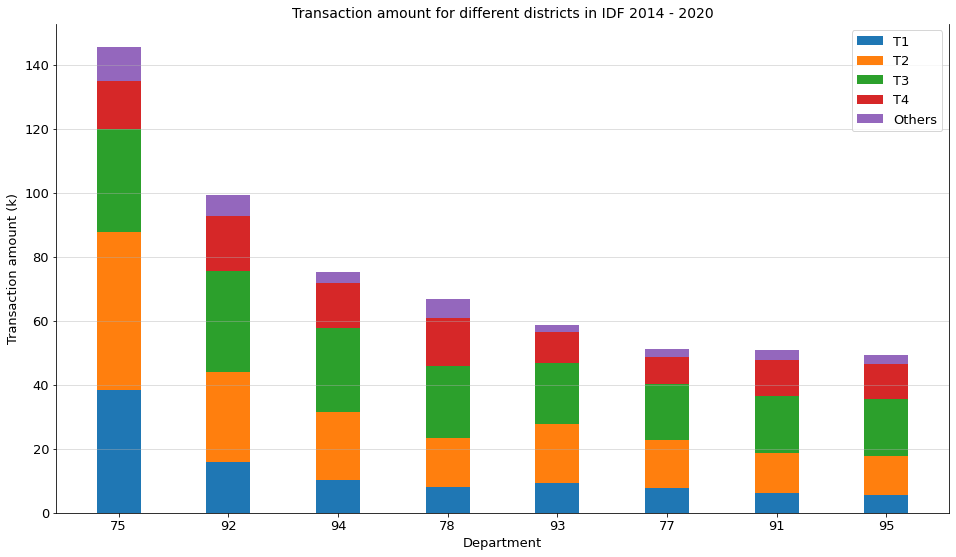

In [28]:
width = 0.4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.set_title('Transaction amount for different districts in IDF 2014 - 2020',
                fontdict={'fontsize': 14})

rects1 = ax.bar(commune_piece_sales.code_departement,
               commune_piece_sales.T1,
               width=width)
rects2 = ax.bar(commune_piece_sales.code_departement,
               commune_piece_sales.T2,
               bottom=commune_piece_sales.T1,
               width=width)
rects3 = ax.bar(commune_piece_sales.code_departement,
               commune_piece_sales.T3,
               bottom=commune_piece_sales.T1 + commune_piece_sales.T2,
               width=width)
rects4 = ax.bar(commune_piece_sales.code_departement,
               commune_piece_sales.T4,
               bottom=commune_piece_sales.T1 + commune_piece_sales.T2 + commune_piece_sales.T3,
               width=width)
rects5 = ax.bar(commune_piece_sales.code_departement,
               commune_piece_sales.Others,
               bottom=commune_piece_sales.T1 + commune_piece_sales.T2 + commune_piece_sales.T3 + commune_piece_sales.T4,
               width=width)

ax.tick_params(labelsize=13)
ax.set_xlabel('Department', size=13)
ax.set_ylabel('Transaction amount (k)', size=13)

ax.grid(axis='y', which='major', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(formatter_thousands)
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]),
          ('T1', 'T2', 'T3', 'T4', 'Others'),
          fontsize=13)

plt.show()
# plt.savefig('unit_price_piece_number_district.png', bbox_inches='tight')

According to this map, we observe that the second-hand apartments in the center and west of Paris are more expensive( > 9k euros per m2) than other districts of Paris(7k - 9k euros per m2), the second-hand apartments in Paris are more expensive than other departments of IDF. Among the departments except for Paris, the second-hand apartments in Hauts-de-Seine are more expensive(4k - 6k euros per m2).

In the light of the stacked bar chart, it's obvious that there are much more transactions in Paris, although it's much more expensive than other departments, no matter which class of apartments. In Paris, 60% transactions sold studio or 2-room apartment; but in other department, the majority of transactions sold 2-room or 3-room apartments. One of the reasons might be the unit price in Paris is more expensive, the studio or 2-room apartment can satisfy the needs of people who live alone or in couple and satisfy the need of investors; on the contrary, people who live with family prefer the apartments outside Paris, they are larger and less expensive.

## Relationship between area & apartment price for different departments

In [29]:
def scatter_area_price(ax, vf, code_departement, title, col_nb=None, row_nb=None):
    ax.set_title(title, fontdict={'fontsize': 11})
    ax.scatter(x=vf[vf['code_departement']==code_departement].surface_reelle_bati,
               y=vf[vf['code_departement']==code_departement].valeur_fonciere,
               s=1, alpha=0.6, label=title)
    ax.plot([0, 210], [0, 2100000], color='tomato', linestyle='--')
    ax.set_ylim(bottom=0, top=2400000)
    ax.set_xlim(left=0, right=210)
    ax.yaxis.set_major_formatter(formatter_millions_1dec)
    
    if col_nb == 0:
        ax.set_ylabel('Price (million €)', size=11)
    else:
        ax.get_yaxis().set_ticklabels([])
    
    if row_nb == 1:
        ax.set_xlabel('Area (m2)', size=11)


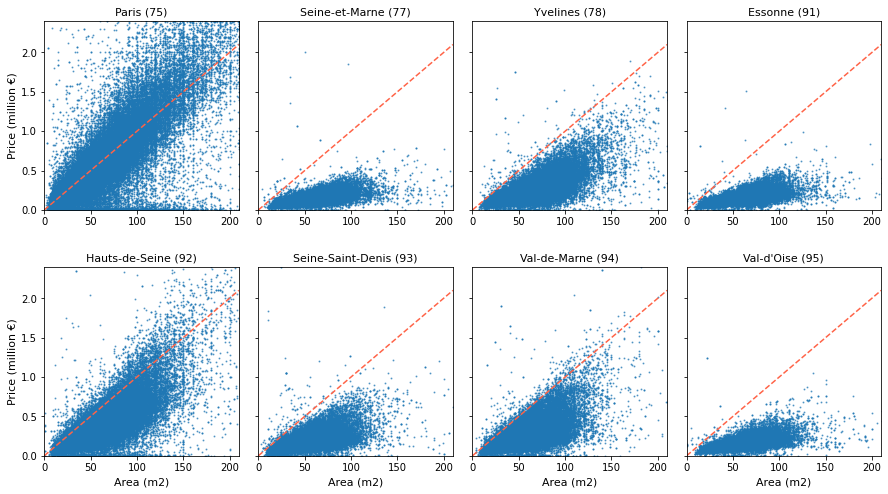

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

scatter_area_price(ax[0, 0], vf, code_departement=75, title='Paris (75)', col_nb=0)
scatter_area_price(ax[0, 1], vf, code_departement=77, title='Seine-et-Marne (77)')
scatter_area_price(ax[0, 2], vf, code_departement=78, title='Yvelines (78)')
scatter_area_price(ax[0, 3], vf, code_departement=91, title='Essonne (91)')

scatter_area_price(ax[1, 0], vf, code_departement=92, title='Hauts-de-Seine (92)', col_nb=0, row_nb=1)
scatter_area_price(ax[1, 1], vf, code_departement=93, title='Seine-Saint-Denis (93)', row_nb=1)
scatter_area_price(ax[1, 2], vf, code_departement=94, title='Val-de-Marne (94)', row_nb=1)
scatter_area_price(ax[1, 3], vf, code_departement=95, title='Val-d\'Oise (95)', row_nb=1)

plt.subplots_adjust(hspace=.3, wspace=.1)
plt.show()
# plt.savefig('area_price_district.png', bbox_inches='tight')

According to this group of scatter plots, we can simply get the relationship between second-hand apartments’ price and their area. Each point stands for one transaction, the plots on the red dash line mean that the price per m2 of these transactions is 10k euros. The points above the dash line indicate their unit price are greater than 10k euros; otherwise, it’s less than 10k euros per m2.

For the transactions in Paris, most of sold apartments are smaller than 150 m2, the unit price is around 10k euros per m2. However, for the transaction in other departments, most of apartments are smaller than 100 m2, the unit price is lower than 10k euros per m2; especially in Seine-et-Marne(77), Essonne(91) and Val-d'Oise(95), we can even get a 100 m2 second-hand apartment with only 0.25 million euros, which is much cheaper than other departments.

## Time seris: seasonal decomposition

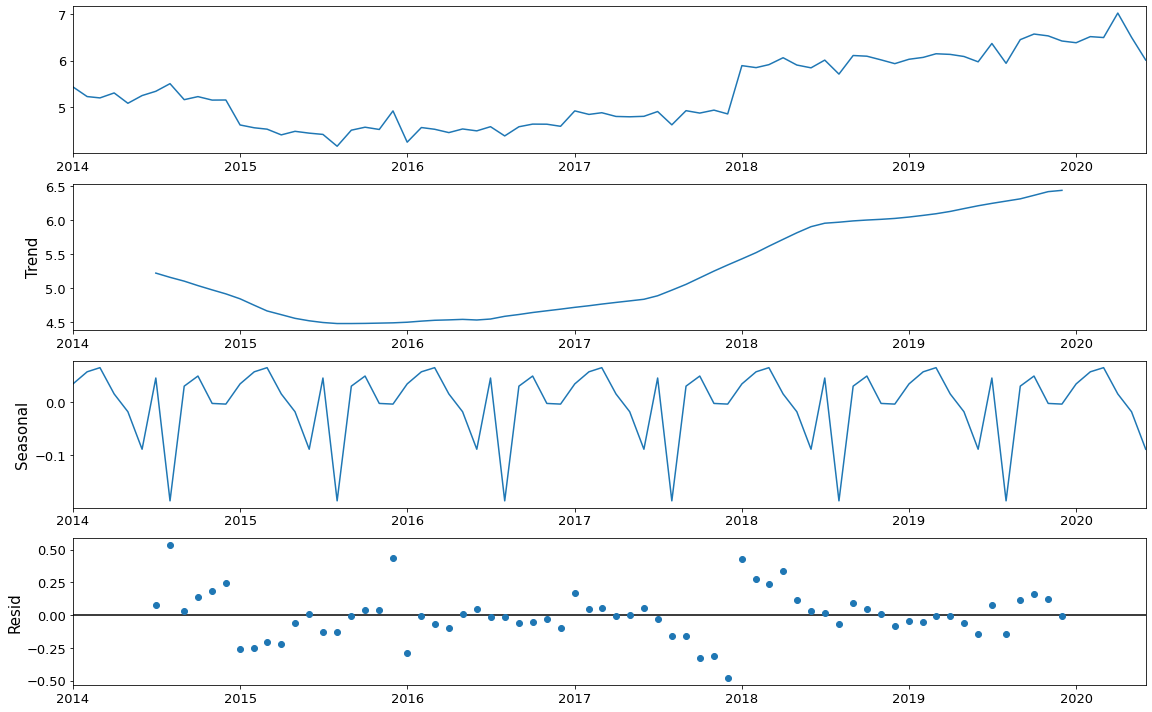

In [32]:
import statsmodels.api as sm
decomp_df = mth_df.copy()
decomp_df = decomp_df[['Month', 'avg_valeurK_m2']]
decomp_df['Month'] = pd.to_datetime(decomp_df['Month'])
decomp_df = decomp_df.set_index('Month')

dcpst = sm.tsa.seasonal_decompose(decomp_df)
fig = dcpst.plot()
matplotlib.rcParams['figure.figsize'] = [16.0, 10.0]
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.labelsize'] = 15

I used Time Series `additive` model to decompose data into a trend component, a seasonal component and a residual component. The trend component captures changes over time, the seasonal component captures cyclical effects due to the time of year, the residual component captures the influences not described by the trend and seasonal effects. Thanks to this model, we find that except for July, there are another transaction peak in March, which we didn’t find above. In June and August, the transactions arrive at their low points, that might be because during the transition period between 2 months, the desire for purchasing or selling apartments is not that high.

## Time series: prediction on monthly price

In [33]:
mth_prophet = mth_df[6:].copy()
mth_prophet = mth_prophet.drop(columns='nb_mutation')
mth_prophet = mth_prophet.rename(columns={'Month': 'ds', 'avg_valeurK_m2': 'y'})

In [34]:
import fbprophet

# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(mth_prophet)

# Make a future dataframe for 5 years
gm_forecast = gm_prophet.make_future_dataframe(periods=12 * 5, freq='m')# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


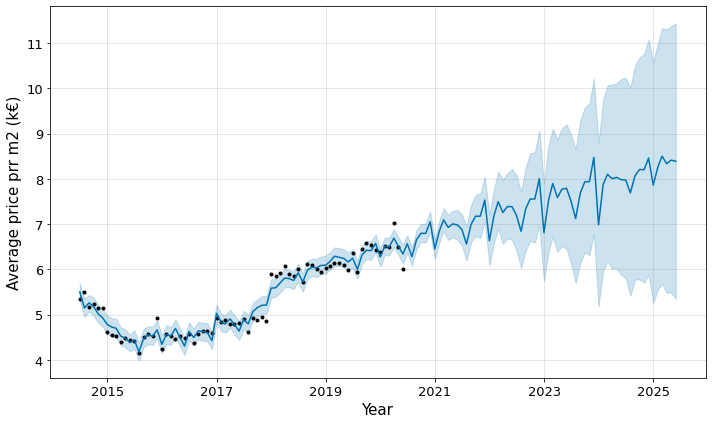

In [35]:
gm_prophet.plot(gm_forecast, xlabel = 'Year', ylabel = 'Average price prr m2 (k€)')
# plt.savefig('price_prediction.png', bbox_inches='tight')

The blacks points present actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty. The uncertainty’s region increases for the prediction because of the initial uncertainty and it grows over time. This can be impacted by policy, social elements, or some others.